In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [2]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [3]:
base_path = './combined-real-and-fake-faces/combined-real-vs-fake/'

image_gen = ImageDataGenerator(rescale=1./255.)

batch_size=8

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 102041 images belonging to 2 classes.


In [4]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [5]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [6]:
train_steps = 100000//batch_size
valid_steps = 20000//batch_size

history = model.fit(
    train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps
)

Epoch 1/10
12500/12500 [==============================] - 2649s 211ms/step - loss: 0.6742 - accuracy: 0.5716 - val_loss: 0.6020 - val_accuracy: 0.6781
Epoch 2/10
12500/12500 [==============================] - 2521s 202ms/step - loss: 0.5165 - accuracy: 0.7455 - val_loss: 0.4899 - val_accuracy: 0.7677
Epoch 3/10
12500/12500 [==============================] - 2533s 203ms/step - loss: 0.3858 - accuracy: 0.8298 - val_loss: 0.3101 - val_accuracy: 0.8683
Epoch 4/10
12500/12500 [==============================] - 2525s 202ms/step - loss: 0.2826 - accuracy: 0.8827 - val_loss: 0.2389 - val_accuracy: 0.9006
Epoch 5/10
12500/12500 [==============================] - 2528s 202ms/step - loss: 0.2106 - accuracy: 0.9161 - val_loss: 0.1914 - val_accuracy: 0.9230
Epoch 6/10
12500/12500 [==============================] - 2539s 203ms/step - loss: 0.1599 - accuracy: 0.9372 - val_loss: 0.1644 - val_accuracy: 0.9357
Epoch 7/10
12500/12500 [==============================] - 2543s 203ms/step - loss: 0.1243 - ac

In [7]:
model.save('densenet_model.h5')

In [8]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

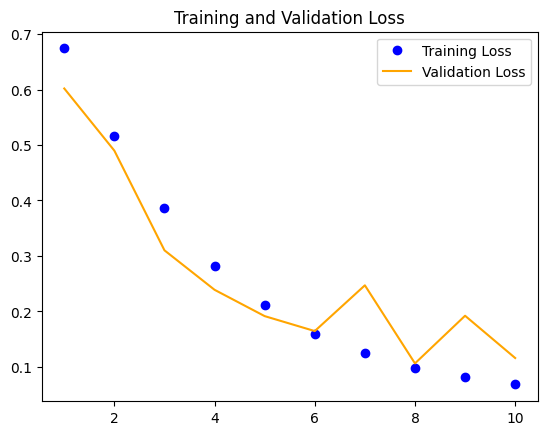

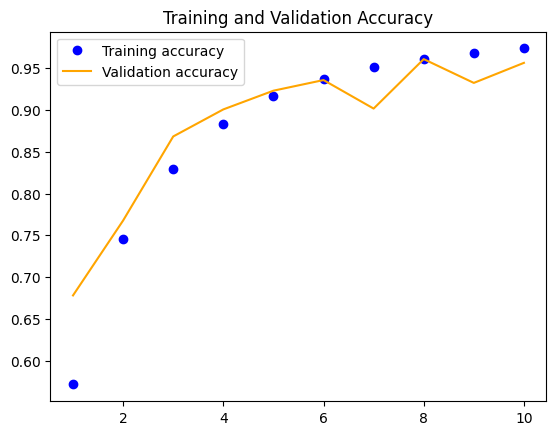

In [10]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [11]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred = model.predict(test_flow)
y_test = test_flow.classes

Found 20000 images belonging to 2 classes.
20000/20000 [==============================] - 564s 28ms/step


In [12]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9916197
AP Score: 0.9913023525056573

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10000
           1       0.96      0.96      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

